# A Basic Statistical Model in PyTorch

## Nearest Neighbors

$f:R \rightarrow \{0, 1\}$
- find closest x in data
- return corresponding y

In [1]:
# %load_ext autoreload
# %autoreload 2

import torch
import torchvision
from PIL import Image


## Image Visualization
+

In [2]:
def visualize_image(img):
    img = 255 * img.permute(1, 2, 0)
    img = img.byte().numpy()

    return Image.fromarray(img)

In [3]:
def split_data(dataset, n=100):
    imgs = []
    labels = []

    for i in range(len(dataset)):
        if i > 1000:
            break

        x, y = dataset[i]
        imgs.append(x)
        labels.append(y)

    imgs = torch.stack(imgs, dim=0)
    labels = torch.as_tensor(labels, dtype=torch.long)

    l1 = 0
    l2 = 4

    mask = (labels == l1) | (labels == l2)
    imgs = imgs[mask]
    labels = labels[mask]
    labels[labels == l1] = 0
    labels[labels == l2] = 1

    return imgs[:n], labels[:n]

In [4]:
size = (128, 128)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size), torchvision.transforms.ToTensor()])

In [5]:
train_dataset = torchvision.datasets.Flowers102("/tmp/flowers", "train", transform=transform, download=True)

In [6]:
# For NN, We'll need to split the data directly
imgs, labels = split_data(train_dataset)

In [7]:
print(f"{imgs.shape = }")
print(f"{imgs.dtype = }")

imgs.shape = torch.Size([20, 3, 128, 128])
imgs.dtype = torch.float32


In [8]:
print(f"{labels.shape = }")
print(f"{labels.dtype = }")

labels.shape = torch.Size([20])
labels.dtype = torch.int64


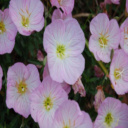

In [9]:
# show a pink flower image
pink = imgs[labels == 0]

visualize_image(pink[0])

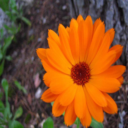

In [10]:
# show a orange image
orange = imgs[labels == 1]

visualize_image(orange[0])

# Nearest Neighbor Classifier

Let us look at a simple classifier called k-nearest neighbor (kNN) classifier.

The idea is the following: given a new point, we predict it label based on the labels from a subset of $k$ training
sample that are *closest* to the new point.

Or put it in a more mathematical way:

We are given a training set $\mathcal{D}=\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \cdots, (\mathbf{x}_N, y_N)\}$
and a new data point $\mathbf{x}$.

The k-NN classifier is a function $f(\mathbf{x}): \mathbb{R} \rightarrow \{0, 1\} $ that does the following:

(1) it computes the distance of each training sampleto the new point
$\mathbf{x}$: $d_1=|\mathbf{x}_1 - \mathbf{x}|, \cdots, d_N=|\mathbf{x}_N - \mathbf{x}|$;

(2) it sorts $\{ d_1, \cdots, d_N \}$ in ascending order into $\{ d_{i_1}, \cdots, d_{i_k}, \cdots , d_{i_N} \}$,
where $ d_{i_1} < \cdots < d_{i_k} < \cdots < d_{i_N} $;

(3) it predicts the new point's label based on the *mode* of $\{ y_{i_1}, \cdots, y_{i_k} \}$.
(Mode refers to the value that appears most in the set)

$ f(\mathbf{x}) = Mode(\{ y_{i_1}, \cdots, y_{i_k} \}) $

In [11]:
def knn_classify(x_train, y_train, x_input, k=3):
    # Compute distances between x and all examples in the training set
    distances = ((x_input - x_train) ** 2).sum(dim=(1, 2, 3)).sqrt()

    # Sort by distance and return indices of the first k neighbors
    k_indices = torch.argsort(distances)[:k]
    # Extract the labels of the k nearest neighbor training samples
    k_nearest_labels = y_train[k_indices]

    (labels, cnts) = torch.unique(k_nearest_labels, return_counts=True)
    idx = torch.argmax(cnts)

    return labels[idx]


def knn_regression(x_train, y_train, x_input, k=3):
    # Compute distances between x and all examples in the training set
    distances = ((x_input - x_train) ** 2).sum(dim=(1, 2, 3)).sqrt()

    # Sort by distance and return indices of the first k neighbors
    k_indices = torch.argsort(distances)[:k]
    # Extract the labels of the k nearest neighbor training samples
    k_nearest_labels = y_train[k_indices]

    return k_nearest_labels.mean()


idx = 1
prediction = knn_classify(imgs, labels, imgs[idx], k=3)
label = labels[idx]

print(f"{prediction = }")
print(f"{label = }")

prediction = tensor(0)
label = tensor(0)


In [12]:
class KNN:
    def __init__(self, x, y, k=3, task="classifipinkion"):
        self.X_train = x
        self.y_train = y

        self.k = k
        self.task = task

    def predict(self, x):
        predicted_labels = [self._predict(x_i).item() for x_i in x]
        return torch.tensor(predicted_labels)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = ((x - self.X_train) ** 2).sum(dim=(1, 2, 3)).sqrt()

        # Sort by distance and return indices of the first k neighbors
        k_indices = torch.argsort(distances)[: self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = self.y_train[k_indices]

        if self.task == "classifipinkion":
            # return the most common class label
            (labels, cnts) = torch.unique(k_nearest_labels, return_counts=True)
            idx = torch.argmax(cnts)
            return labels[idx]

        elif self.task == "regression":
            # return the mean of the labels (fix the tensor warning)
            return torch.mean(k_nearest_labels.float())


# Fit the KNN model with the training data
knn = KNN(imgs, labels, k=3, task="classifipinkion")

idx = 12
prediction = knn.predict(imgs[idx : idx + 1])
label = labels[idx]

print(f"{prediction = }")
print(f"{label = }")

prediction = tensor([1])
label = tensor(1)


## Testing the Model

len(imgs_test) = 65
Ground truth label:  0
Predicted label:  tensor(0)


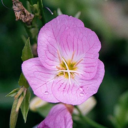

In [13]:
test_dataset = torchvision.datasets.Flowers102("/tmp/flowers", "test", transform=transform)
imgs_test, labels_test = split_data(test_dataset)

print(f"{len(imgs_test) = }")
print("Ground truth label: ", labels_test[0].item())
print("Predicted label: ", knn.predict(imgs_test)[0])

visualize_image(imgs_test[0])

## Quantifying Performance

In [14]:
preds = knn.predict(imgs_test)
accuracy = (preds == labels_test).sum() / len(labels_test)

print("Accuracy: ", accuracy.item())

Accuracy:  0.9384615421295166


# Nearest Neighbor Regression

We can also use the Nearest Neighbor model for regression.

The difference is that we use the average of the nearest neighbors' labels as the prediction.

Recall that we use the label 0 for pinks and 1 for oranges. Instead of make this a classifipinkion problem,
we can make it a regression problem.

Here we try to regress to value (orangeness): the probability of being a orange (1) instead of a pink (0).

In this way, we can test on images that are not pinks or oranges and see their orangeness.

## Load and fit the KNN regressor

In [15]:
# Fit the KNN regression model with the training data
# We use K=10 to get a smoother regression result

knn = KNN(imgs, labels, k=10, task="regression")

## Test the model on pink/orange flowers

In [16]:
pink_idx = labels_test[labels_test == 0][0]
orange_idx = labels_test[labels_test == 1][0]

print("Ground truth label: ", labels_test[pink_idx].item())
print("Predicted label: ", knn.predict(imgs_test[pink_idx : pink_idx + 1]).item())

print("Ground truth label: ", labels_test[orange_idx].item())
print("Predicted label: ", knn.predict(imgs_test[orange_idx : orange_idx + 1]).item())

Ground truth label:  0
Predicted label:  0.20000000298023224
Ground truth label:  0
Predicted label:  0.4000000059604645
